# Initial investigation of rework of thesis related to optimizing admittance in a force guided assembly task

In [106]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
from matplotlib.collections import PatchCollection
from matplotlib import cm as mcm

In [ ]:
# Define constraints
PENALTYFACTOR=75
INIT_MAX_THETA=pi/36
INIT_MIN_THETA=-pi/36
INIT_MAX_X=1.87
INIT_MAX_Y=24.5  # Can be scalled depending on part geometry
INIT_MIN_X=-1.87
INIT_MIN_Y=0
DP_INIT=13

xPAPos=2e-1
xPANeg=-2e-1
yPAPos=1e-1
yPANeg=-1e-1
thetaPAPos=0.0872664626
thetaPANeg=-0.0872664626
thresh=1.0e-3

In [173]:
# Convinience plotting function
def plot_poly(objs_disp):
  fig, ax = plt.subplots()
  
  patches=[]
  for poly in objs_disp:
    patches.append(poly)
  p=PatchCollection(patches, edgecolor="k", alpha=0.5, cmap=mcm.jet)
  colors = 100*np.random.random(len(patches))
  p.set_array(colors)
  ax.add_collection(p)
  ax.autoscale_view()
  ax.set_aspect('equal','box')
  plt.show()


def plot_shape(shapes):
  fig, ax = plt.subplots()
  for shape in shapes:
    ax.add_patch(shape)
  ax.autoscale_view()
  ax.set_aspect('equal','box')
  plt.show()

We are a bit lazy so we go ahead and define the vertices for the objects here, this was done to save time with parsing dxf files.

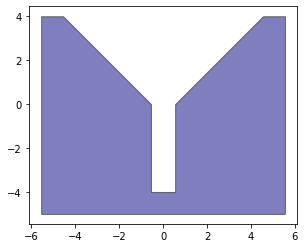

In [174]:
VertA=np.array([
[-5.55, 4],
[-5.55, -5],
[5.55, -5],
[5.55, 4 ],
[4.55, 4],
[0.55, 0],
[0.55, -4],
[-0.55, -4],
[-0.55, 0],
[-4.55, 4 ]
])

figObjA=mpatches.Polygon(VertA)
plot_poly([figObjA])

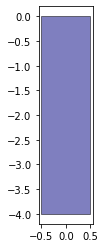

In [183]:
VertB=[
[0.5, -4],
[-0.5, -4],
[-0.5, 0],
[0.5, 0],
]

figObjB=mpatches.Polygon(VertB)
plot_poly([figObjB])

Now we can see the end result of the assembly task, a square peg inside a slot

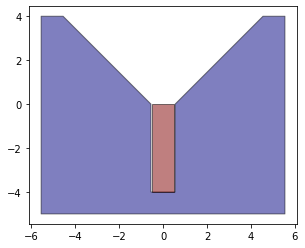

In [176]:
plot_poly([figObjA, figObjB])

Since we are doing a bunch of transformations we are using shapely instead

In [177]:
from shapely.geometry import Polygon, LineString, LinearRing
from descartes import PolygonPatch

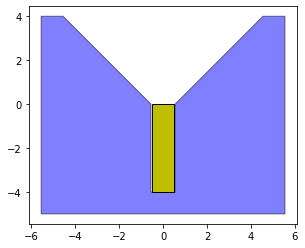

In [178]:
polygonA = Polygon(VertA)
patchA = PolygonPatch(polygonA, fc="b", alpha=0.5)
polygonB = Polygon(VertB)
patchB = PolygonPatch(polygonB, fc="y")
plot_shape([patchA, patchB])

Get all the normals of the lines

In [269]:
def prepare_object(Vert):
  #Check that object is defined as ccw
  LRObjB=LinearRing(Vert)
  if LRObjB.is_ccw is not True:
    Vert=[x for x in reversed(Vert)]
  Lines=[]
  Vectors=[]
  VectorsNorm=[]
  Edges=[]
  Verts2=[]

  # For each create an edge, a shapely line and also due to how we want iterate
  # rework our Vertices to mantain the shape. Normalize our Vectors
  for i in range(len(Vert)):
    Edge=[Vert[i-1],Vert[i]]
    Edges.append(Edge)
    Line=LineString([Vert[i-1],Vert[i]])
    Lines.append(Line)
    Verts2.append(Vert[-i])
    Vector=np.array(Vert[i-1])-np.array(Vert[i])
    Vectors.append(Vector)
    VectorNorm = Vector/np.linalg.norm(Vector)
    VectorsNorm.append(VectorNorm)

  print("Edges")
  print('\n'.join('{}: {}'.format(*k) for k in enumerate(Edges)))

  # Get the vectors of each 2D object.Super easy for 2D 
  Normals=[]
  for V in VectorsNorm:
    Norm=np.array([-V[1],V[0]])
    Normals.append(Norm)

  print("Normals")
  print('\n'.join('{}: {}'.format(*k) for k in enumerate(Normals)))

  print("Vectors")
  print('\n'.join('{}: {}'.format(*k) for k in enumerate(Vectors)))
  print("Vectors Normalized")
  print('\n'.join('{}: {}'.format(*k) for k in enumerate(VectorsNorm)))
  Obj={}
  Obj['Vertices']=np.asarray(Verts2)
  Obj['Edges']=Edges
  Obj['Lines']=Lines
  Obj['Vectors']=Vectors
  Obj['VectorsNorm']=VectorsNorm
  Obj['Normals']=Normals
  return Obj

In [270]:
ObjA=prepare_object(VertA)

Edges
0: [array([-4.55,  4.  ]), array([-5.55,  4.  ])]
1: [array([-5.55,  4.  ]), array([-5.55, -5.  ])]
2: [array([-5.55, -5.  ]), array([ 5.55, -5.  ])]
3: [array([ 5.55, -5.  ]), array([5.55, 4.  ])]
4: [array([5.55, 4.  ]), array([4.55, 4.  ])]
5: [array([4.55, 4.  ]), array([0.55, 0.  ])]
6: [array([0.55, 0.  ]), array([ 0.55, -4.  ])]
7: [array([ 0.55, -4.  ]), array([-0.55, -4.  ])]
8: [array([-0.55, -4.  ]), array([-0.55,  0.  ])]
9: [array([-0.55,  0.  ]), array([-4.55,  4.  ])]
Normals
0: [-0.  1.]
1: [-1.  0.]
2: [-0. -1.]
3: [1. 0.]
4: [-0.  1.]
5: [-0.70710678  0.70710678]
6: [-1.  0.]
7: [-0.  1.]
8: [1. 0.]
9: [0.70710678 0.70710678]
Vectors
0: [1. 0.]
1: [0. 9.]
2: [-11.1   0. ]
3: [ 0. -9.]
4: [1. 0.]
5: [4. 4.]
6: [0. 4.]
7: [1.1 0. ]
8: [ 0. -4.]
9: [ 4. -4.]
Vectors Normalized
0: [1. 0.]
1: [0. 1.]
2: [-1.  0.]
3: [ 0. -1.]
4: [1. 0.]
5: [0.70710678 0.70710678]
6: [0. 1.]
7: [1. 0.]
8: [ 0. -1.]
9: [ 0.70710678 -0.70710678]


In [271]:
ObjB=prepare_object(VertB)

Edges
0: [[0.5, -4], [0.5, 0]]
1: [[0.5, 0], [-0.5, 0]]
2: [[-0.5, 0], [-0.5, -4]]
3: [[-0.5, -4], [0.5, -4]]
Normals
0: [1. 0.]
1: [-0.  1.]
2: [-1.  0.]
3: [-0. -1.]
Vectors
0: [ 0. -4.]
1: [1. 0.]
2: [0. 4.]
3: [-1.  0.]
Vectors Normalized
0: [ 0. -1.]
1: [1. 0.]
2: [0. 1.]
3: [-1.  0.]


Define our edges and also our vectors and normalize them

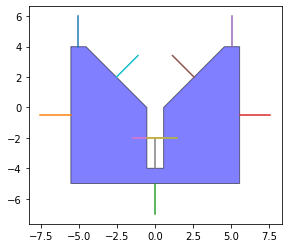

In [289]:
fig, ax= plt.subplots()

polygonA = Polygon(ObjA['Vertices'])
patchA = PolygonPatch(polygonA, fc="b", alpha=0.5)

for e,n in zip(ObjA['Edges'], ObjA['Normals']):
  mdpt=(np.add(e[0],e[1]))/2
  scnd=mdpt+n*2
  L=LineString([mdpt, scnd])
  x,y=L.xy
  plt.plot(x,y)

ax.add_patch(patchA)
ax.autoscale_view()
ax.set_aspect('equal','box')
plt.show()


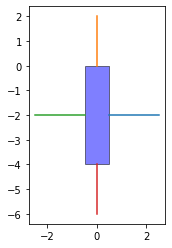

In [291]:
fig, ax= plt.subplots()

polygonB = Polygon(ObjB['Vertices'])
patchB = PolygonPatch(polygonB, fc="b", alpha=0.5)

for e,n in zip(ObjB['Edges'], ObjB['Normals']):
  mdpt=np.add(e[0],e[1])/2
  scnd=mdpt+n*2
  L=LineString([mdpt, scnd])
  x,y=L.xy
  plt.plot(x,y)

ax.add_patch(patchB)
ax.autoscale_view()
ax.set_aspect('equal','box')

In [315]:
for i in range(len(VertB)):
  x1=np.take(ObjB['Vertices'],i-1, axis=0, mode='wrap')
  x2=np.take(ObjB['Vertices'],i, axis=0, mode='wrap')
  x3=np.take(ObjB['Vertices'],i+1, axis=0, mode='wrap')
  print(x1,x2,x3)

[-0.5  0. ] [0.5 0. ] [ 0.5 -4. ]
[0.5 0. ] [ 0.5 -4. ] [-0.5 -4. ]
[ 0.5 -4. ] [-0.5 -4. ] [-0.5  0. ]
[-0.5 -4. ] [-0.5  0. ] [0.5 0. ]


In [310]:
ObjB['Vertices']

array([[ 0.5,  0. ],
       [ 0.5, -4. ],
       [-0.5, -4. ],
       [-0.5,  0. ]])